In [0]:
import os 
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [0]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['bird', 'deer', 'ship', 'airplane', 'horse', 'frog', 'cat', 'truck', 'automobile', 'dog']


## Cool, we have the data stored in a organized manner with images belonging to one class grouped up in a single folder with the class name as the folder name. 

Using pytorchs Imagefolder and an transform operation on the images while loading.

will give us the image tensor and the classes

In [0]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [0]:
train_dir = data_dir + "/train"
dataset = ImageFolder(train_dir, transform=ToTensor())

In [10]:
# exploring the datast object
for image, label in dataset:
  print(image.shape)
  print(label)
  print(dataset.classes[label])
  break

torch.Size([3, 32, 32])
0
airplane


In [0]:
# to display a RGB image we need to reformat it to (x, y, 3)
def show_img(img, label):
  plt.imshow(img.permute(1,2,0))
  plt.title(dataset.classes[label])

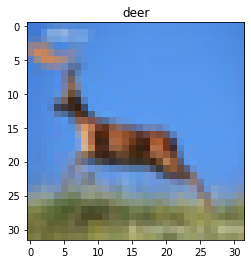

In [12]:
idx = np.random.randint(0, len(dataset))
show_img(*dataset[idx])

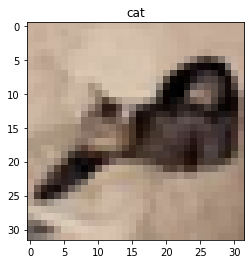

In [13]:
idx = np.random.randint(0, len(dataset))
show_img(*dataset[idx])

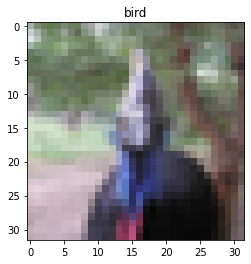

In [14]:
idx = np.random.randint(0, len(dataset))
show_img(*dataset[idx])

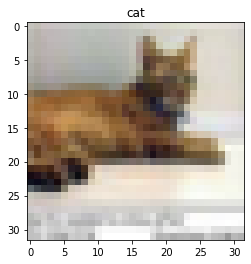

In [15]:
idx = np.random.randint(0, len(dataset))
show_img(*dataset[idx])

cool we have loaded the data lets continue

---
# Training Validation Split

In [0]:
def split_indices(len, val_split, seed=15):
  split_point = int(len*val_split)
  np.random.seed(seed)
  idxs = np.random.permutation(len)
  return idxs[split_point:], idxs[:split_point]

In [17]:
train_idxs, val_idxs = split_indices(len(dataset), 0.2)
print(f"No of training samples : {len(train_idxs)}")
print(f"No of validation samples : {len(val_idxs)}")

No of training samples : 40000
No of validation samples : 10000


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [0]:
batch_size = 100

In [0]:
train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size, sampler = val_sampler)

## lets look at some of the images

In [0]:
from torchvision.utils import make_grid

In [0]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    break

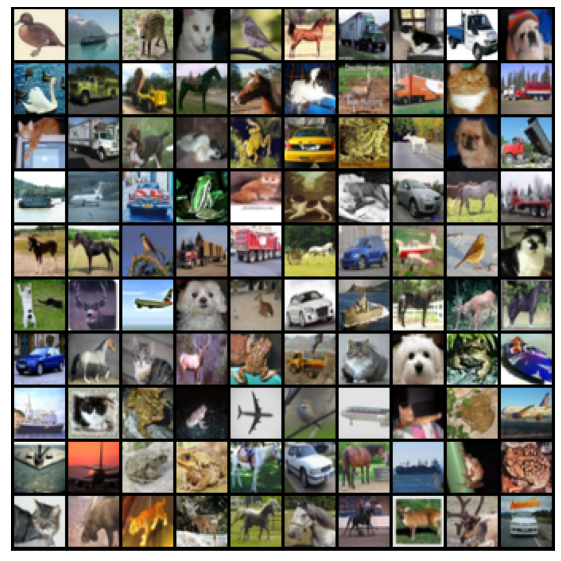

In [23]:
show_batch(train_dl)

## Building the Sequential Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 16 x 16
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 8 x 8

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 2 x 2

    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: bs x 16 x 1 x 1,
    
    nn.Flatten(), # output: bs x 16
    nn.Linear(16, 10) # output: bs x 10 
)

# Lets start working on the GPU now

In [26]:
# defining some helper functions 

def get_default_device():
  if  torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)
  
device = get_default_device()
print(f"selected device: {device}")

selected device: cuda


In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len(self):
    return len(self.dl)

In [28]:
# moving it all to the GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=16, out_features=10, bias=True)
)

# Training the model

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [32]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, 
                                    val_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3140, Accuracy: 0.0988


In [0]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, 
        opt_fn=None, lr=None, metric=None):
  history = {
    "loss" : [],
    "val_loss" : [],
    "metric": [],
    "epoch": []
    }
    
  # Instantiate the optimizer
  if opt_fn is None: 
    opt_fn = torch.optim.SGD

  opt = opt_fn(model.parameters(), lr=lr)
  
  for epoch in range(epochs):
    losses = []
    lens = []
    # Training
    model.train()
    for xb,yb in train_dl:
        b_loss,b_len,_ = loss_batch(model, loss_fn, xb, yb, opt)
        losses.append(b_loss)
        lens.append(b_len)
    
    loss = np.sum(np.multiply(losses, lens))/ np.sum(lens)

    # Evaluation
    model.eval()
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, _, val_metric = result
    
    # log progress
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['epoch'].append(epoch)
    
    # Print progress
    if metric is None:
      print(f"Epoch: [{epoch+1}/{epochs}] --> loss: {loss}, val_loss: {val_loss}")
    else:
      history['metric'].append(val_metric)
      print(f"Epoch: [{epoch+1}/{epochs}] --> loss: {loss}, val_loss: {val_loss},  {metric.__name__}: {val_metric}")

  return history

In [0]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [35]:
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, val_dl, opt_fn, lr, accuracy)

Epoch: [1/10] --> loss: 1.8576788279414176, val_loss: 1.7908378672599792,  accuracy: 0.3455
Epoch: [2/10] --> loss: 1.5862229409813882, val_loss: 1.512483627796173,  accuracy: 0.4531
Epoch: [3/10] --> loss: 1.4598697793483735, val_loss: 1.3874078118801116,  accuracy: 0.4945
Epoch: [4/10] --> loss: 1.3650386077165604, val_loss: 1.3886288237571716,  accuracy: 0.4969
Epoch: [5/10] --> loss: 1.3238980498909951, val_loss: 1.3284786820411683,  accuracy: 0.5186
Epoch: [6/10] --> loss: 1.266742068529129, val_loss: 1.229197164773941,  accuracy: 0.5594
Epoch: [7/10] --> loss: 1.227529394775629, val_loss: 1.2160675013065338,  accuracy: 0.5667
Epoch: [8/10] --> loss: 1.201011374592781, val_loss: 1.2170808279514314,  accuracy: 0.5681
Epoch: [9/10] --> loss: 1.1686933229863643, val_loss: 1.1626165509223938,  accuracy: 0.5837
Epoch: [10/10] --> loss: 1.1446977680921555, val_loss: 1.1843893313407898,  accuracy: 0.5732


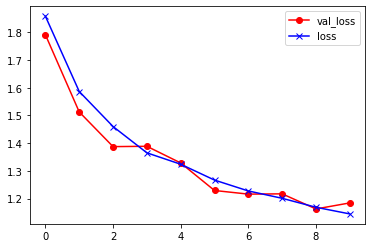

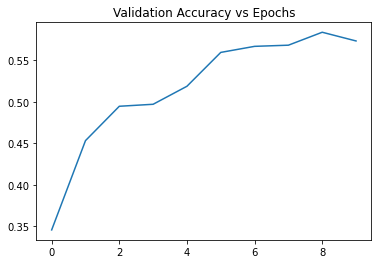

In [37]:
plt.plot(history['epoch'], history['val_loss'], '-ro', label='val_loss')
plt.plot(history['epoch'], history['loss'], '-bx', label='loss')
plt.legend(loc='best')
plt.show()

plt.plot(history['epoch'], history['metric'])
plt.title('Validation Accuracy vs Epochs')
plt.show()

In [0]:
torch.save(model.state_dict(), "mnist-cnn.pth")

##Lets train further and see how the model performs with a reduced lr

Epoch: [1/10] --> loss: 1.0451888506114484, val_loss: 1.0856626045703888,  accuracy: 0.6139
Epoch: [2/10] --> loss: 1.024898771494627, val_loss: 1.0737571209669112,  accuracy: 0.6159
Epoch: [3/10] --> loss: 1.0185738740861416, val_loss: 1.0695845311880112,  accuracy: 0.622
Epoch: [4/10] --> loss: 1.0052180971205233, val_loss: 1.0706089127063751,  accuracy: 0.6189
Epoch: [5/10] --> loss: 1.0001011960208417, val_loss: 1.0835079181194305,  accuracy: 0.6122
Epoch: [6/10] --> loss: 0.9936217691004277, val_loss: 1.0733432179689408,  accuracy: 0.619
Epoch: [7/10] --> loss: 0.9889585408568382, val_loss: 1.0633640438318253,  accuracy: 0.6186
Epoch: [8/10] --> loss: 0.984472319483757, val_loss: 1.07601072371006,  accuracy: 0.617
Epoch: [9/10] --> loss: 0.9830902083218098, val_loss: 1.0734755057096481,  accuracy: 0.6157
Epoch: [10/10] --> loss: 0.9745027999579906, val_loss: 1.0692722171545028,  accuracy: 0.6191


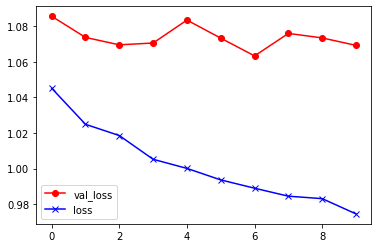

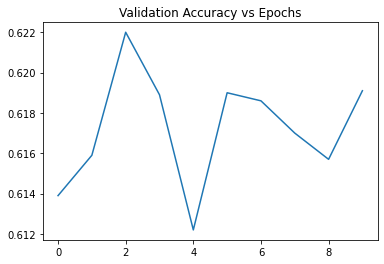

In [39]:
lr = 0.001
history = fit(num_epochs, model, F.cross_entropy, 
              train_dl, val_dl, opt_fn, lr, accuracy)

plt.plot(history['epoch'], history['val_loss'], '-ro', label='val_loss')
plt.plot(history['epoch'], history['loss'], '-bx', label='loss')
plt.legend(loc='best')
plt.show()

plt.plot(history['epoch'], history['metric'])
plt.title('Validation Accuracy vs Epochs')
plt.show()

In [0]:
def predict_image(img, label, model):
  plt.imshow(img.permute(1,2,0))
  xb = img.unsqueeze(0)
  xb = xb.to(device, non_blocking=True)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  plt.title(f"Prediction : {dataset.classes[preds[0].item()]} // True label: {dataset.classes[label]}")
  plt.show()

In [0]:
test_dir = data_dir + "/test"
dataset = ImageFolder(test_dir, transform=ToTensor())

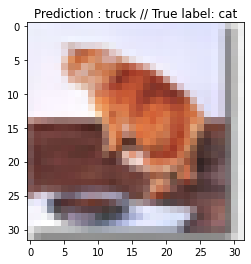

In [76]:
idx = np.random.randint(0, len(test_dataset))
image, label = dataset[idx]
predict_image(image, label, model)

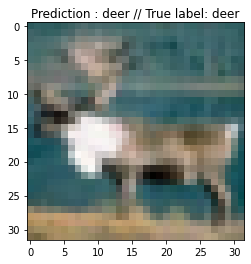

In [84]:
idx = np.random.randint(0, len(test_dataset))
image, label = dataset[idx]
predict_image(image, label, model)

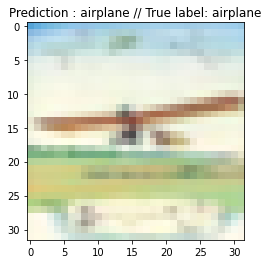

In [85]:
idx = np.random.randint(0, len(test_dataset))
image, label = dataset[idx]
predict_image(image, label, model)

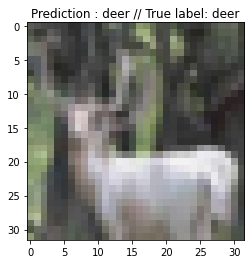

In [79]:
idx = np.random.randint(0, len(test_dataset))
image, label = dataset[idx]
predict_image(image, label, model)

We seem to be starting to overfit, we need to regularize the data, possibily with the help of Image Augmentation

---
# Coolio Bai